# Train word2vec CBOW Model with gensim

Subject: Training word embeddings with gensim Word2vec (CBOW algorithm) representing the words' closeness to each other.

Data: Unlabeled "txtlab_Novel150_English" dataset with 150 English novels written over the long nineteenth century

Procedure:
- Tokenizing to sentences with nltk's sentence tokenizer nltk.data.load('tokenizers/punkt/english.pickle') 
- Tokenizing words with nltk.tokenize.word_tokenize
- Training a gensim.models.word2vec.Word2Vec model
- Evaluation with gensim's model.wv.doesnt_match(), model.wv.most_similar(), model.wv.n_similarity(), model.wv.most_similar_cosmul() including the canonical King - Man + Woman -> Queen test (passed)
- Wordclouds for male and female-associated words
- Good results (not reproduced with custom Torch models, cf. other notebooks)

Others:
- working on Colab with Google Drive for loading data

Sources used:
- https://github.com/data-8/literature-connector/blob/gh-pages/13%20-%20The%20Cutting%20Edge/Word%20Embedding.ipynb
- https://www.kaggle.com/code/erenat77/word2vec-with-gensim-word2vec/notebook

In [30]:
if IN_COLAB := 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = './drive/MyDrive/Colab/'
    import nltk
    nltk.download('punkt')

else:
    BASE_PATH = '../'

import locale
locale.setlocale(locale.LC_ALL, locale='de_DE.utf8')  # for thousands separator via ... print(f'{value:n}')

'de_DE.utf8'

## Dataset

In [8]:
import pandas as pd

In [9]:
PATH_METADATA_TABLE = BASE_PATH + 'data/novel/txtlab_Novel150_English.csv'
PATH_DIR_NOVELS = BASE_PATH + 'data/novel/txtlab_Novel150_English/'

metadata_tb = pd.read_csv(PATH_METADATA_TABLE)  # contains novel filenames

In [10]:
novels: list[str] = []

for filename in metadata_tb['filename']:
    with open(PATH_DIR_NOVELS+filename, 'r', encoding="utf8") as file_in:
        novel = file_in.read()
    
    # add the whole novel text as single string
    novels.append(novel)

print(f"Read list of {len(novels)} Novels.")

Read list of 150 Novels.


In [11]:
print('Extract from 16th novel:\n\n', novels[15][1003:1105])

Extract from 16th novel:

  evils that flow from an erroneous or imperfect discipline.
My state is not destitute of tranquillity.


## Preprocessing

We currently have our novels as a list of huge strings.
1. First, we split each novel into its sentences. 
2. Then, we split each sentence into its words.

In [12]:
import nltk
import string

### Tokenize Sentences

In [13]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [14]:
sentences = [sentence for novel in novels for sentence in sentence_tokenizer.tokenize(novel)]
print(f'Tokenized {len(sentences)} sentences from {len(novels)} novels.')

Tokenized 961915 sentences from 150 novels.


### Tokenize Words

In [15]:
# to remove punctuation
translator = str.maketrans('', '', string.punctuation + '“”')

In [16]:
# Print some example
original_sentence = sentences[111]
print(f'Original sentence  : {original_sentence}')

sentence_without_punctuation = original_sentence.translate(translator)
print(f'Without punctuation: {sentence_without_punctuation}')

tokenized = nltk.tokenize.word_tokenize(sentence_without_punctuation, language='english')
print(f'Tokenized:           {tokenized}')

Original sentence  : “Our delicacies,” said Harley to himself, “are fantastic; they are not in nature!
Without punctuation: Our delicacies said Harley to himself are fantastic they are not in nature
Tokenized:           ['Our', 'delicacies', 'said', 'Harley', 'to', 'himself', 'are', 'fantastic', 'they', 'are', 'not', 'in', 'nature']


In [17]:
sentences_without_punctuation =  [s.translate(translator) for s in sentences]
print(f'Removed punctuation from {len(sentences_without_punctuation)} sentences.')

Removed punctuation from 961915 sentences.


In [18]:
tokenized_sentences = [nltk.tokenize.word_tokenize(s, language='english') for s in sentences_without_punctuation]
print(f'Tokenized {len(tokenized_sentences)} sentences.')

Tokenized 961915 sentences.


In [19]:
words_by_sentence = [s for s in tokenized_sentences if s != []]
print(f'Removed {len(tokenized_sentences) - len(words_by_sentence)} sentences with empty content.')

Removed 1704 sentences with empty content. 960211 tokenized sentences remaining.


In [31]:
print(f'Final number of sentences: {len(words_by_sentence) :n}')
print(f'Final number of tokens: {len([w for s in words_by_sentence for w in s]) :n}')

Final number of sentences: 960.211
Final number of tokens: 18.544.081


In [23]:
# some examples
print(words_by_sentence[10000:10020])

[['I', 'fancy', 'said', 'Lord', 'Orville', 'when', 'he', 'was', 'gone', 'I', 'have', 'shortened', 'Mr', 'Macartneys', 'visit'], ['No', 'my', 'Lord', 'not', 'at', 'all'], ['I', 'had', 'presumed', 'said', 'he', 'with', 'some', 'hesitation', 'I', 'should', 'have', 'seen', 'Miss', 'Anville', 'in', 'the', 'gardenbut', 'I', 'knew', 'not', 'she', 'was', 'so', 'much', 'better', 'engaged'], ['Before', 'I', 'could', 'answer', 'a', 'servant', 'came', 'to', 'tell', 'me', 'the', 'chaise', 'was', 'ready', 'and', 'that', 'Mrs', 'Selwyn', 'was', 'enquiring', 'for', 'me'], ['I', 'will', 'wait', 'on', 'her', 'immediately', 'cried', 'I', 'and', 'away', 'I', 'was', 'running', 'but', 'Lord', 'Orville', 'stopping', 'me', 'said', 'with', 'great', 'emotion', 'Is', 'it', 'thus', 'Miss', 'Anville', 'you', 'leave', 'me'], ['My', 'Lord', 'cried', 'I', 'how', 'can', 'I', 'help', 'itperhaps', 'soon', 'some', 'better', 'opportunity', 'may', 'offer', 'Good', 'Heaven'], ['cried', 'he', 'do', 'you', 'take', 'me', 'for'

## gensim word2vec Model

In [33]:
from gensim.models import word2vec

In [62]:
model = word2vec.Word2Vec( words_by_sentence,
                           workers=4,  # Number of parallel threads
                           vector_size=200,  # dimensionality of the word vectors.
                           window=5,  # max. distance between the current and predicted word within a sentence.
                           min_count=5,  #ignores all words with total frequency lower than this.
                           sample=1e-3,  # (0.001) Downsample setting for frequent words
                           alpha=0.025,  # initial learning rate
                           epochs=5,  # num of iterations (epochs) over the corpus. 
                           sg=0,  # CBOW (default) - 1 would be skip-gram
                         )

### Save

In [63]:
# Saving the model for later use. Can be loaded using Word2Vec.load()
model.save(BASE_PATH + "saves/my_model.model")

## Evaluation

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [65]:
# Few tests: This will print the odd word among them 
model.wv.doesnt_match("man woman king queen princess dog".split())

'dog'

In [66]:
model.wv.doesnt_match("europe africa USA turkey".split())

'turkey'

In [67]:
model.wv.most_similar("best")

[('worst', 0.5841414928436279),
 ('better', 0.48326870799064636),
 ('wisest', 0.47766923904418945),
 ('greatest', 0.46609756350517273),
 ('kindest', 0.46445614099502563),
 ('finest', 0.45891618728637695),
 ('good', 0.4458419382572174),
 ('strongest', 0.4419524669647217),
 ('duty', 0.4301691949367523),
 ('easiest', 0.4254176616668701)]

In [68]:
model.wv.most_similar("best")

[('worst', 0.5841414928436279),
 ('better', 0.48326870799064636),
 ('wisest', 0.47766923904418945),
 ('greatest', 0.46609756350517273),
 ('kindest', 0.46445614099502563),
 ('finest', 0.45891618728637695),
 ('good', 0.4458419382572174),
 ('strongest', 0.4419524669647217),
 ('duty', 0.4301691949367523),
 ('easiest', 0.4254176616668701)]

In [69]:
model.wv.most_similar_cosmul(positive=['man', 'woman'], negative=['princess'])

[('fellow', 1.0830003023147583),
 ('gentleman', 1.015393853187561),
 ('mans', 0.9922693967819214),
 ('person', 0.9904364943504333),
 ('girl', 0.9839566946029663),
 ('creature', 0.9747808575630188),
 ('lady', 0.960570216178894),
 ('wretch', 0.9546177983283997),
 ('chap', 0.9521641135215759),
 ('sinner', 0.9255192279815674)]

In [70]:
model.wv.most_similar('sense','sensibility')

[('sup', 0.27668920159339905),
 ('Square', 0.2677241265773773),
 ('railway', 0.267670601606369),
 ('City', 0.26292380690574646),
 ('oot', 0.2616136968135834),
 ('done', 0.2582820951938629),
 ('Road', 0.2565248906612396),
 ('Corner', 0.25539979338645935),
 ('tae', 0.25088590383529663),
 ('aboot', 0.24967460334300995)]

In [71]:
# Find cosine distance between two clusters of word vectors
# Each cluster is measured as the mean of its words
model.wv.n_similarity(['sense','sensibility'],['whale','harpoon'])

0.14830044

In [72]:
# Finds mean vector of words in list
# and identifies the word further from that mean
model.wv.doesnt_match(['pride','prejudice', 'harpoon'])

'harpoon'

In [73]:
# The canonic word2vec exercise: King - Man + Woman -> Queen
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6735777258872986),
 ('Emperor', 0.6100078821182251),
 ('priest', 0.5881226062774658),
 ('Princess', 0.5852726697921753),
 ('Virgin', 0.5841646194458008),
 ('princess', 0.5840868949890137),
 ('prince', 0.5768553614616394),
 ('saint', 0.5721543431282043),
 ('minister', 0.5577689409255981),
 ('heathen', 0.5487199425697327)]

In [74]:
model.wv.most_similar(positive=['she','her','hers','herself'], 
                      negative=['he','him','his','himself'])

[('lovely', 0.4022843837738037),
 ('girlish', 0.3947155773639679),
 ('maiden', 0.39369451999664307),
 ('beautiful', 0.3784404397010803),
 ('beauteous', 0.35836124420166016),
 ('charming', 0.3532736599445343),
 ('husbands', 0.35215863585472107),
 ('lover', 0.34880197048187256),
 ('charms', 0.3451729118824005),
 ('sweet', 0.344234436750412)]

In [75]:
model.wv.most_similar(positive=['he','him','his','himself'], 
                      negative=['she','her','hers','herself'])


[('horse', 0.36078664660453796),
 ('Banner', 0.3522818088531494),
 ('gun', 0.3460504114627838),
 ('Buck', 0.3401283323764801),
 ('whip', 0.3342313766479492),
 ('Bill', 0.33055830001831055),
 ('bicycle', 0.3291621506214142),
 ('Peoples', 0.3232056498527527),
 ('mate', 0.3229079246520996),
 ('Moby', 0.32173100113868713)]

In [76]:
# get words strongly associated with female gender
her_tokens = [token for token,weight in model.wv.most_similar
              (positive=['he','him','his','himself'],
               negative=['she','her','hers','herself'], 
               topn=50)]
her_tokens[:10]

['horse',
 'Banner',
 'gun',
 'Buck',
 'whip',
 'Bill',
 'bicycle',
 'Peoples',
 'mate',
 'Moby']

In [77]:
# wordcloud for male-gender-associated words
male_associated: list[tuple[str, float]] = model.wv.most_similar(positive=['he','him','his','himself'], 
                                                                 negative=['she','her','hers','herself'],
                                                                 topn=50)
male_associated_int: list[tuple[str, float]] = [(w, round(m*100)) for (w, m) in male_associated]
male_associated_words_multiplied: list[list[str]] = [[w] * i for (w, i) in male_associated_int]
male_words_flat: list[str] = [w for words in male_associated_words_multiplied for w in words]
male_words: str = ' '.join(male_words_flat)

# wordcloud for female-gender-associated words
female_associated: list[tuple[str, float]] = model.wv.most_similar(positive=['she','her','hers','herself'], 
                                                                 negative=['he','him','his','himself'],
                                                                 topn=50)
female_associated_int: list[tuple[str, float]] = [(w, round(m*100)) for (w, m) in female_associated]
female_associated_words_multiplied: list[list[str]] = [[w] * i for (w, i) in female_associated_int]
female_words_flat: list[str] = [w for words in female_associated_words_multiplied for w in words]
female_words: str = ' '.join(female_words_flat)

word_cloud_male = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        ).generate(male_words)

word_cloud_female = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        ).generate(female_words)


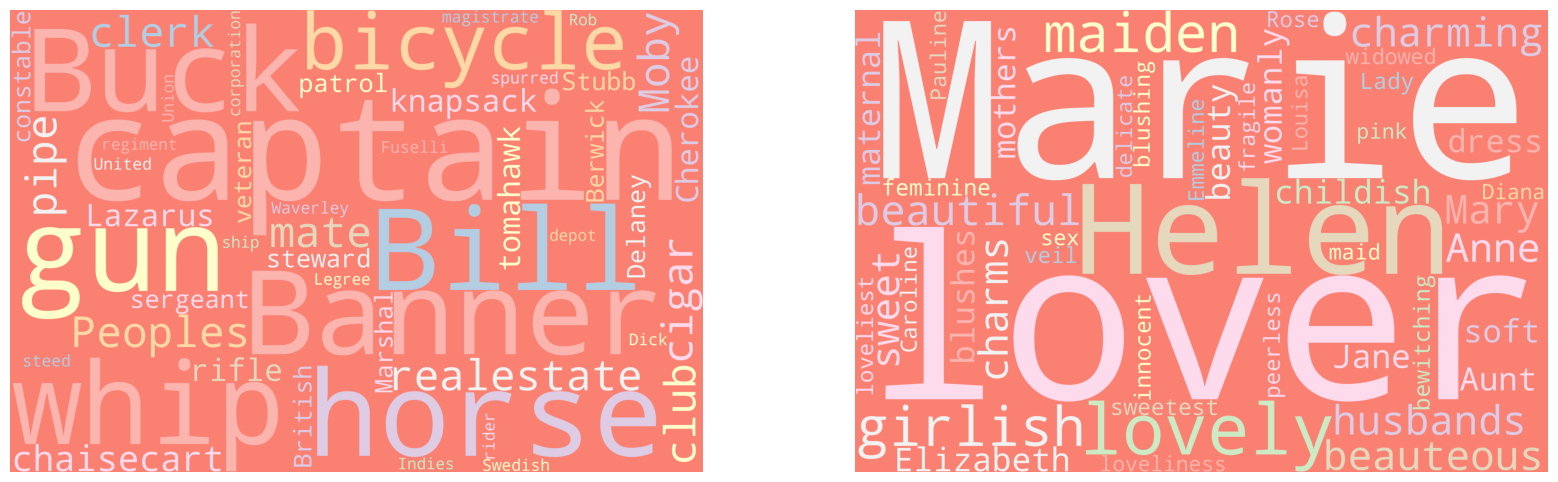

In [78]:
_fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.imshow(word_cloud_male)
ax2.imshow(word_cloud_female)
ax1.axis("off")
ax2.axis("off")
plt.show()

### Load trained Model

In [79]:
pretrained_model = word2vec.Word2Vec.load(BASE_PATH + "saves/my_model.model")

In [80]:
pretrained_model.wv.doesnt_match(['pride','prejudice', 'harpoon'])

'harpoon'